# Project description and General Information

You work as an analyst for the telecom operator *Megaline*. The company offers its clients two prepaid plans: "Surf and Ultimate". 

The commercial department wants to know which of the plans brings in more revenue in order to adjust the advertising budget.

- You are going to carry out a preliminary analysis of the plans based on a relatively small client selection.
- You'll have the data on 500 Megaline clients: 
    - who the clients are, 
    - where they're from, 
    - which plan they use, and 
    - the number of calls they made and text messages they sent in 2018. 
- Your job is to analyze clients' behavior and determine which prepaid plan brings in more revenue.

# Description of the plans

Note: Megaline rounds seconds up to minutes, and megabytes to gigabytes. For calls, each individual call is rounded up: even if the call lasted just one second, it will be counted as one minute. For web traffic, individual web sessions are not rounded up. Instead, the total for the month is rounded up. If someone uses 1025 megabytes this month, they will be charged for 2 gigabytes.

**Surf**

1. Monthly charge:$$20$
2. 500 monthly minutes, 50 texts, and 15 GB of data
3. After exceeding the package limits:
    - 1 minute: 3 cents
    - 1 text message: 3 cents
    - 1 GB of data: $10

**Ultimate**

1. Monthly charge: $$70$
2. 3000 monthly minutes, 1000 text messages, and 30 GB of data

3. After exceeding the package limits:
    - 1 minute: 1 cent
    - text message: 1 cent
    - GB of data: $7

# Outline

<div class="alert alert-info"> 
    <ol>
      <li><a href="#1">Description of the data</a></li>
      <li><a href="#2">Open the data file and study the general information</a></li>
      <li><a href="#3">Prepare the data</a></li>
      <li><a href="#4">Analyze the data</a></li>
      <li><a href="#5">Test the hypotheses</a></li>
      <li><a href="#6">Overall conclusion</a></li>
    </ol> 
</div>

# <a id="1">Description of the data</a>

The `users` table (data on users):
- *user_id* — unique user identifier
- *first_name* — user's name
- *last_name* — user's last name
- *age* — user's age (years)
- *reg_date* — subscription date (dd, mm, yy)
- *churn_date* — the date the user stopped using the service (if the value is missing, the calling plan was being used when this database was extracted)
- *city* — user's city of residence
- *plan* — calling plan name

The `calls` table (data on calls):
- *id* — unique call identifier
- *call_date* — call date
- *duration* — call duration (in minutes)
- *user_id* — the identifier of the user making the call

The `messages` table (data on texts):
- *id* — unique text message identifier
- *message_date* — text message date
- *user_id* — the identifier of the user sending the text

The `internet` table (data on web sessions):
- *id* — unique session identifier
- *mb_used* — the volume of data spent during the session (in megabytes)
- *session_date* — web session date
- *user_id* — user identifier

The `plans` table (data on the plans):
- *plan_name* — calling plan name
- *usd_monthly_fee* — monthly charge in US dollars
- *minutes_included* — monthly minute allowance
- *messages_included* — monthly text allowance
- *mb_per_month_included* — data volume allowance (in megabytes)
- *usd_per_minute* — price per minute after exceeding the package limits (e.g., if the package includes 100 minutes, the 101st minute will be charged)
- *usd_per_message* — price per text after exceeding the package limits
- *usd_per_gb* — price per extra gigabyte of data after exceeding the package limits (1 GB = 1024 megabytes)

***The objective of this project is to study and analyse Magaline's subscribers behaviour, and determine which prepaid plan (Surf/Ultimate) is more profitable.***

***Plans of action for this data is to apply Analytics, Data Viz and Statistical Data Analysis for the adverstising budget and the plan's prediction.***

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline 
import numpy as np
import math as mt
from math import factorial
from scipy import stats as st
from sklearn.preprocessing import FunctionTransformer
import seaborn as sns
import re
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from scipy import stats

# <a id="2">Open the data file and study the general information</a>

We have 5 datasets:
Let's Open our data files

In [2]:
try:
    calls = pd.read_csv('megaline_calls.csv') 
    internet = pd.read_csv('megaline_internet.csv')
    messages = pd.read_csv('megaline_messages.csv')
    plans = pd.read_csv('megaline_plans.csv')
    users = pd.read_csv('megaline_users.csv')
except:
    calls = pd.read_csv('/datasets/megaline_calls.csv')
    internet = pd.read_csv('/datasets/megaline_internet.csv')
    messages = pd.read_csv('/datasets/megaline_messages.csv')
    plans = pd.read_csv('/datasets/megaline_plans.csv')
    users = pd.read_csv('/datasets/megaline_users.csv')

### Functions

In [3]:
#For an overal first look on the data
def data_info(df):
    print('---------------------------------------')
    print('Shape: \n{}'.format(df.shape))
    print()
    print('General Info:')
    print(df.info())
    print()
    print('First five rows: \n{}'.format(df.head()))
    print()
    print('Last five rows: \n{}'.format(df.tail()))
    print()
    print('Statistical details: \n{}'.format(df.describe()))
    print()
    print('How many duplicates?\n')
    print('We have {} duplicates.'.format(df.duplicated().sum()))
    print()
    print('Are there any NAs?')
    print(df.isna().sum(),'\n')
    print('Missing data percent \n')
    print(df.isna().mean().reset_index())
    print('---------------------------------------')

# split column into day, month and year
def date_columns(df):
    columns = df.columns.tolist()
    idx = [columns.index(x) for x in columns if 'date' in x][0]
    
    df['day'] = df[columns[idx]].dt.day_name()
    df['month'] = df[columns[idx]].dt.month_name()
    df['year'] = df[columns[idx]].dt.year
    return df
#remove the user id from other tables ids
extract_id = np.vectorize(lambda x: re.sub('.*_', '' ,  x))

#change date columns to date type and split to day/month/year
def get_date(df):
    columns = df.columns.tolist()
    idx = [columns.index(x) for x in columns if 'date' in x][0]
    
    df[columns[idx]] = pd.to_datetime(df[columns[idx]])
    df['day'] = df[columns[idx]].dt.day_name()
    df['month'] = df[columns[idx]].dt.month_name()
    df['year'] = df[columns[idx]].dt.year
    return df
#fct for surf/ultimate plans histogram ploting
def plot_hists(df1,df2,column):
    ax = df1.hist(column=column,density=True, bins=30)
    df2.hist(column=column,density=True, bins=30, alpha=0.5,ax =ax)
    plt.legend(['surf','ultimate'])

- **`users` data**

In [4]:
data_info(users)

---------------------------------------
Shape: 
(500, 8)

General Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
first_name    500 non-null object
last_name     500 non-null object
age           500 non-null int64
city          500 non-null object
reg_date      500 non-null object
plan          500 non-null object
churn_date    34 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None

First five rows: 
   user_id first_name  last_name  age                                   city  \
0     1000   Anamaria      Bauer   45  Atlanta-Sandy Springs-Roswell, GA MSA   
1     1001     Mickey  Wilkerson   28        Seattle-Tacoma-Bellevue, WA MSA   
2     1002     Carlee    Hoffman   36   Las Vegas-Henderson-Paradise, NV MSA   
3     1003   Reynaldo    Jenkins   52                          Tulsa, OK MSA   
4     1004    Leonila   Thompson   40        Seattle-Tacoma-Bellevue, WA MSA   


**Conclusion**

- `churn_date` column: 93% of NAs. Maybe the meaning is that no churn for the other users, we'll see in the data preproc part.
- `churn_date` and `reg_date` columns must be date_time type.

***

- **`calls` data**

In [5]:
data_info(calls)

---------------------------------------
Shape: 
(137735, 4)

General Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
id           137735 non-null object
user_id      137735 non-null int64
call_date    137735 non-null object
duration     137735 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB
None

First five rows: 
         id  user_id   call_date  duration
0   1000_93     1000  2018-12-27      8.52
1  1000_145     1000  2018-12-27     13.66
2  1000_247     1000  2018-12-27     14.48
3  1000_309     1000  2018-12-28      5.76
4  1000_380     1000  2018-12-30      4.22

Last five rows: 
              id  user_id   call_date  duration
137730  1499_199     1499  2018-11-21      8.72
137731  1499_200     1499  2018-10-20     10.89
137732  1499_201     1499  2018-09-21      8.12
137733  1499_202     1499  2018-10-10      0.37
137734  1499_203     1499  2018-12-29     13.86

Statistical details:

**Conclusion**
- No NAs in `calls` dataset and no duplicates.
- `id` column contains 2 ids, the first one is the user id (we already have this column). We can delete the first part and change the data type.
- We can change the `call_date` column type into data type.
- we can make a categorization for `duration` column, for example for durations = 0 it will be missed calls...

***

- **`internet` data**

In [6]:
data_info(internet)

---------------------------------------
Shape: 
(104825, 4)

General Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
id              104825 non-null object
user_id         104825 non-null int64
session_date    104825 non-null object
mb_used         104825 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB
None

First five rows: 
         id  user_id session_date  mb_used
0   1000_13     1000   2018-12-29    89.86
1  1000_204     1000   2018-12-31     0.00
2  1000_379     1000   2018-12-28   660.40
3  1000_413     1000   2018-12-26   270.99
4  1000_442     1000   2018-12-27   880.22

Last five rows: 
              id  user_id session_date  mb_used
104820  1499_215     1499   2018-10-20   218.06
104821  1499_216     1499   2018-12-30   304.72
104822  1499_217     1499   2018-09-22   292.75
104823  1499_218     1499   2018-12-07     0.00
104824  1499_219     1499   2018-12-24   758.31

Statisti

**Conclusion**

- No NAs.
- like previous columns, changing date columns is a must.
- `id` column, same concluion as in the `calls` table.
- `mb_used`, same as in the previous table, we can make a categorization for this column. 

***

**`messages` data**

In [7]:
data_info(messages)

---------------------------------------
Shape: 
(76051, 3)

General Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
id              76051 non-null object
user_id         76051 non-null int64
message_date    76051 non-null object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB
None

First five rows: 
         id  user_id message_date
0  1000_125     1000   2018-12-27
1  1000_160     1000   2018-12-31
2  1000_223     1000   2018-12-31
3  1000_251     1000   2018-12-27
4  1000_255     1000   2018-12-26

Last five rows: 
             id  user_id message_date
76046  1497_526     1497   2018-12-24
76047  1497_536     1497   2018-12-24
76048  1497_547     1497   2018-12-31
76049  1497_558     1497   2018-12-24
76050  1497_613     1497   2018-12-23

Statistical details: 
            user_id
count  76051.000000
mean    1245.972768
std      139.843635
min     1000.000000
25%     1123.000000
50%     1251.000000
75%     1362.00000

- No NAs.
- same conclusions for `id` and dates columns.

***

**`plans` data**

In [8]:
data_info(plans)

---------------------------------------
Shape: 
(2, 8)

General Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
usd_monthly_pay          2 non-null int64
usd_per_gb               2 non-null int64
usd_per_message          2 non-null float64
usd_per_minute           2 non-null float64
plan_name                2 non-null object
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes
None

First five rows: 
   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute plan_name  
0               20          10             0.03            0.03      surf  
1               70           7             0.01   

In [9]:
plans.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


Let's move to data preparation.

***

# <a id="3">Prepare the data</a>

**Task 1**
- Convert the data to the necessary types

In [10]:
users.info()
calls.info()
internet.info()
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
first_name    500 non-null object
last_name     500 non-null object
age           500 non-null int64
city          500 non-null object
reg_date      500 non-null object
plan          500 non-null object
churn_date    34 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
id           137735 non-null object
user_id      137735 non-null int64
call_date    137735 non-null object
duration     137735 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
id              104825 non-null object
user_id         104825 non-null int64
session_date    104825 non-null object
mb_used         104825 non-null fl

***

**Task 2**
- Find and eliminate errors in the data

Explain what errors you found and how you removed them.

**`user` data**

In [11]:
users.isna().sum()

user_id         0
first_name      0
last_name       0
age             0
city            0
reg_date        0
plan            0
churn_date    466
dtype: int64

In [12]:
#change to date type
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d %H:%M:%S')

In [13]:
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d %H:%M:%S')

In [14]:
users.columns = ['user', 'first name', 'last name', 'age', 'city', 'subscription date', 'plan', 'churn date']

In [15]:
users['churn date'].value_counts()

2018-12-18    3
2018-12-31    2
2018-11-14    2
2018-12-19    2
2018-11-16    1
2018-10-03    1
2018-08-16    1
2018-12-15    1
2018-12-12    1
2018-11-11    1
2018-12-26    1
2018-09-07    1
2018-10-22    1
2018-09-18    1
2018-09-01    1
2018-12-10    1
2018-12-27    1
2018-11-30    1
2018-10-13    1
2018-11-24    1
2018-10-07    1
2018-12-22    1
2018-11-21    1
2018-11-18    1
2018-09-17    1
2018-07-31    1
2018-12-30    1
2018-11-29    1
2018-08-19    1
Name: churn date, dtype: int64

In [16]:
users.loc[users['churn date'].isna(),'subscription date'].value_counts()

2018-11-29    5
2018-07-12    5
2018-08-03    5
2018-02-06    5
2018-03-06    4
             ..
2018-10-01    1
2018-12-02    1
2018-01-12    1
2018-04-30    1
2018-12-21    1
Name: subscription date, Length: 255, dtype: int64

For the churn_date, I'm going to create another column to tell whether the client churns(`churn_date`=NaT) or not.

In [17]:
#new column: customer churn
users['customer churn'] = np.where(users['churn date'].isnull(),'No','Yes')

In [18]:
users.head(2)

,user,first name,last name,age,city,subscription date,plan,churn date,customer churn
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaT,No
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,No


**`calls` data**

In [19]:
#convert call_date column to date type
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d %H:%M:%S')

Remove the user id's part from calls id

In [20]:
calls['id'] = extract_id(calls['id'])

In [21]:
calls = get_date(calls)

In [22]:
calls.head(2)

,id,user_id,call_date,duration,day,month,year
0,93,1000,2018-12-27,8.52,Thursday,December,2018
1,145,1000,2018-12-27,13.66,Thursday,December,2018


Now, since we have calls = 0, we're going to add a new column where categorizing between missed calls and connected ones.

In [23]:
def call_category(c):
    if c == 0:
        return 'Missed call'
    else:
        return 'Connected call'

In [24]:
#new column: call type
calls['call type'] = calls['duration'].apply(call_category)

In [25]:
calls.head(2)

,id,user_id,call_date,duration,day,month,year,call type
0,93,1000,2018-12-27,8.52,Thursday,December,2018,Connected call
1,145,1000,2018-12-27,13.66,Thursday,December,2018,Connected call


In [26]:
calls['duration'].min()

0.0

In [27]:
calls['duration'].max()

37.6

In [28]:
calls.loc[calls['duration']<1,'user_id'].value_counts()

1077    302
1324    293
1362    272
1240    263
1334    262
       ... 
1344      2
1323      1
1306      1
1481      1
1034      1
Name: user_id, Length: 479, dtype: int64

We see many calls lasting less than 1 minute. In this case we need to round it to 1min. and round also all the other calls.

In [29]:
calls['duration'] = (calls['duration'].apply(np.ceil)).astype('int64')

In [30]:
# rename columns
calls.columns = ['id', 'user', 'call date', 'duration', 'day', 'month', 'year', 'call type']
calls.head()

,id,user,call date,duration,day,month,year,call type
0,93,1000,2018-12-27,9,Thursday,December,2018,Connected call
1,145,1000,2018-12-27,14,Thursday,December,2018,Connected call
2,247,1000,2018-12-27,15,Thursday,December,2018,Connected call
3,309,1000,2018-12-28,6,Friday,December,2018,Connected call
4,380,1000,2018-12-30,5,Sunday,December,2018,Connected call


**`internet`** data

In [31]:
#change the session_date column type
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d %H:%M:%S')

In [32]:
internet.head(2)

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00


In [33]:
internet['id'] = extract_id(internet['id'])

In [34]:
internet = get_date(internet)

In [35]:
internet['id'] = extract_id(internet['id'])

In [36]:
internet.columns = ['id', 'user', 'session date', 'data used', 'day', 'month', 'year']

In [37]:
internet.head(2)

,id,user,session date,data used,day,month,year
0,13,1000,2018-12-29,89.86,Saturday,December,2018
1,204,1000,2018-12-31,0.00,Monday,December,2018


**`messages` data**

In [38]:
messages['id'] = extract_id(messages['id'])

In [39]:
messages = get_date(messages)

In [40]:
messages.columns = ['id', 'user', 'message date', 'day', 'month', 'year']

In [41]:
messages.head(2)

,id,user,message date,day,month,year
0,125,1000,2018-12-27,Thursday,December,2018
1,160,1000,2018-12-31,Monday,December,2018


**`plans` data**

In [42]:
plans.columns = ['messages included', 'data volume per month', 'minutes included', 'monthly fee', 'price per gb', 'price per message', 'price per minute', 'plan']
plans.head()

,messages included,data volume per month,minutes included,monthly fee,price per gb,price per message,price per minute,plan
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


**Conclusion**

We changed data types, add new columns to categorize our data, lets move to calculations.

**Task 3** Calculations:
- For each user, find:
    - The number of calls made and minutes used per month
    - The number of text messages sent per month
    - The volume of data per month
    - The monthly revenue from each user (subtract the free package limit from the total number of calls, text messages, and data; multiply the result by the calling plan value; add the monthly charge depending on the calling plan)

Now checking if we have data for every user per usage in the other tables

In [43]:
print(users['user'].nunique())
print(calls['user'].nunique())
print(internet['user'].nunique())
print(messages['user'].nunique())

500
481
489
402


As we see, in calls, we do only have onfo for 481 users out of 500, for internet and messages too.

**1:**
- The number of calls made and minutes used per month

In [44]:
#calls per month
calls_per_month = calls.groupby(['user', 'month']).agg({'id': 'count'}).rename(columns={'id': 'calls made'})
calls_per_month

calls made
user month                
1000 December           16
1001 August             27
     December           56
     November           64
     October            65
...                    ...
1498 September          45
1499 December           65
     November           45
     October            53
     September          41

[2258 rows x 1 columns]

In [45]:
#calls and minute per month
calls_min_per_month = calls.groupby(['user','month']).agg({'duration':'sum','id':'count'}).rename(columns={'duration':'minutes used per month','id':'calls Made'})
calls_min_per_month

minutes used per month  calls Made
user month                                        
1000 December                      124          16
1001 August                        182          27
     December                      412          56
     November                      426          64
     October                       393          65
...                                ...         ...
1498 September                     363          45
1499 December                      496          65
     November                      308          45
     October                       385          53
     September                     346          41

[2258 rows x 2 columns]

In [46]:
# minutes per month only
mins_per_month = calls.groupby(['user', 'month']).agg({'duration': 'sum'}).rename(columns={'duration': 'minutes spent'})
mins_per_month

minutes spent
user month                   
1000 December             124
1001 August               182
     December             412
     November             426
     October              393
...                       ...
1498 September            363
1499 December             496
     November             308
     October              385
     September            346

[2258 rows x 1 columns]

**2:**
- The number of text messages sent per month

In [47]:
#message per month
messages_per_month = messages.groupby(['user', 'month']).agg({'id': 'count'}).rename(columns={'id': 'messages sent'})
messages_per_month

messages sent
user month                   
1000 December              11
1001 August                30
     December              44
     November              36
     October               53
...                       ...
1496 December              11
     November              13
     October               18
     September             21
1497 December              50

[1806 rows x 1 columns]

**3:**
- The volume of data per month

In [48]:
#internet per month
internet_per_month = (internet.groupby(['user', 'month']).agg({'data used': 'sum'})/1024).apply(np.ceil)*1024
internet_per_month

data used
user month               
1000 December      2048.0
1001 August        7168.0
     December     19456.0
     November     19456.0
     October      22528.0
...                   ...
1498 September    23552.0
1499 December     22528.0
     November     17408.0
     October      20480.0
     September    13312.0

[2277 rows x 1 columns]

**4:**
- The monthly revenue from each user (subtract the free package limit from the total number of calls, text messages, and data; multiply the result by the calling plan value; add the monthly charge depending on the calling plan)

In [49]:
#conbine into one table
one_table= pd.concat([calls_per_month, mins_per_month, messages_per_month, internet_per_month], axis=1).reset_index().fillna(0)
one_table.columns = ['user', 'month', 'calls made', 'call duration', 'messages sent', 'mb used']
one_table= one_table.merge(users, on='user')
one_table

,user,month,calls made,call duration,messages sent,mb used,first name,last name,age,city,subscription date,plan,churn date,customer churn
0,1000,December,16.0,124.0,11.0,2048.0,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaT,No
1,1001,August,27.0,182.0,30.0,7168.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,No
2,1001,December,56.0,412.0,44.0,19456.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,No
3,1001,November,64.0,426.0,36.0,19456.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,No
4,1001,October,65.0,393.0,53.0,22528.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2288,1498,September,45.0,363.0,0.0,23552.0,Scot,Williamson,51,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-02-04,surf,NaT,No
2289,1499,December,65.0,496.0,0.0,22528.0,Shena,Dickson,37,"Orlando-Kissimmee-Sanford, FL MSA",2018-05-06,surf,NaT,No
2290,1499,November,45.0,308.0,0.0,17408.0,Shena,Dickson,37,"Orlando-Kissimmee-Sanford, FL MSA",2018-05-06,surf,NaT,No
2291,1499,October,53.0,385.0,0.0,20480.0,Shena,Dickson,37,"Orlando-Kissimmee-Sanford, FL MSA",2018-05-06,surf,NaT,No


In [50]:
#merge with plans df
one_table = one_table.merge(plans, left_on='plan', right_on='plan')
one_table.head()

,user,month,calls made,call duration,messages sent,mb used,first name,last name,age,city,...,plan,churn date,customer churn,messages included,data volume per month,minutes included,monthly fee,price per gb,price per message,price per minute
0,1000,December,16.0,124.0,11.0,2048.0,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",...,ultimate,NaT,No,1000,30720,3000,70,7,0.01,0.01
1,1006,December,9.0,59.0,139.0,32768.0,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",...,ultimate,2018-12-18,Yes,1000,30720,3000,70,7,0.01,0.01
2,1006,November,2.0,10.0,15.0,3072.0,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",...,ultimate,2018-12-18,Yes,1000,30720,3000,70,7,0.01,0.01
3,1008,December,85.0,634.0,26.0,15360.0,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",...,ultimate,NaT,No,1000,30720,3000,70,7,0.01,0.01
4,1008,November,63.0,446.0,37.0,24576.0,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",...,ultimate,NaT,No,1000,30720,3000,70,7,0.01,0.01


In [51]:
#The monthly revenue from each user
one_table['message cost'] = one_table.apply(lambda x: max(0, x['messages sent'] - x['messages included']) * x['price per message'],axis = 1)
one_table['call cost'] = one_table.apply(lambda x: max(0, x['call duration'] - x['minutes included']) * x['price per minute'],axis = 1)
one_table['gb cost'] = one_table.apply(lambda x: np.ceil(max(0, x['mb used'] - x['data volume per month'])/1024)*x['price per gb'],axis = 1)
one_table['revenue'] = one_table['message cost'] + one_table['call cost'] + one_table['gb cost'] + one_table['monthly fee']
one_table.head()

,user,month,calls made,call duration,messages sent,mb used,first name,last name,age,city,...,data volume per month,minutes included,monthly fee,price per gb,price per message,price per minute,message cost,call cost,gb cost,revenue
0,1000,December,16.0,124.0,11.0,2048.0,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",...,30720,3000,70,7,0.01,0.01,0.0,0.0,0.0,70.0
1,1006,December,9.0,59.0,139.0,32768.0,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",...,30720,3000,70,7,0.01,0.01,0.0,0.0,14.0,84.0
2,1006,November,2.0,10.0,15.0,3072.0,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",...,30720,3000,70,7,0.01,0.01,0.0,0.0,0.0,70.0
3,1008,December,85.0,634.0,26.0,15360.0,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",...,30720,3000,70,7,0.01,0.01,0.0,0.0,0.0,70.0
4,1008,November,63.0,446.0,37.0,24576.0,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",...,30720,3000,70,7,0.01,0.01,0.0,0.0,0.0,70.0


# <a id="4">Analyze the data</a>

- Describe the customers' behavior. 
- Find the minutes, texts, and volume of data the users of each plan require per month. 
- Calculate the 
    - mean, 
    - variance, and 
    - standard deviation. 
- Plot histograms. 
- Describe the distributions.

**EDA**

In [52]:
# populate the list of numeric and categorical attributes
num_list = []
cat_list = []
plot_data = one_table[['calls made', 'call duration', 'messages sent', 'mb used', 'plan', 'call cost', 'gb cost', 'message cost', 'revenue']]
#fct for loop plot
for column in plot_data:
    if is_numeric_dtype(plot_data[column]):
        num_list.append(column)
    elif is_string_dtype(plot_data[column]):
        cat_list.append(column)
        
print(num_list)
print(cat_list)

['calls made', 'call duration', 'messages sent', 'mb used', 'call cost', 'gb cost', 'message cost', 'revenue']
['plan']


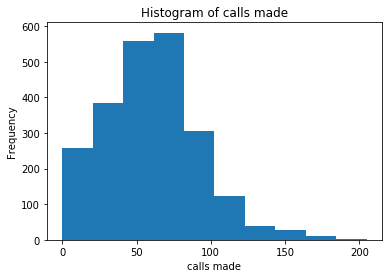

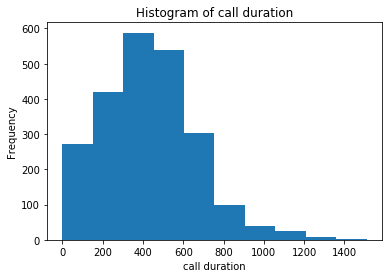

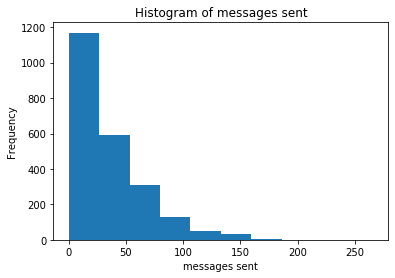

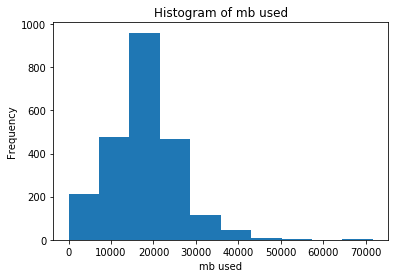

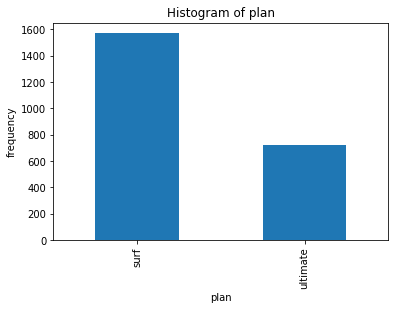

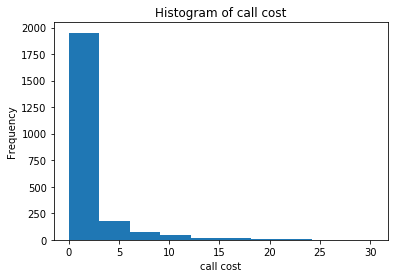

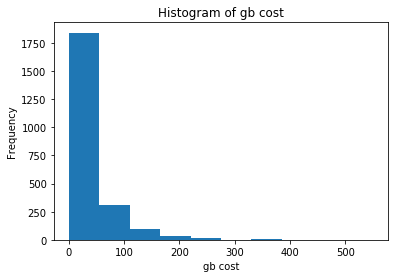

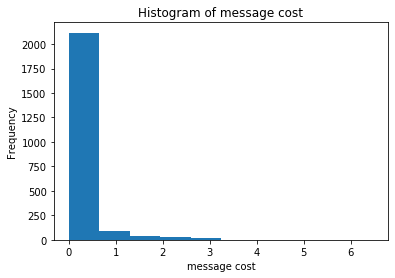

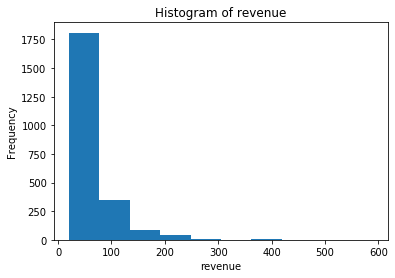

In [53]:
#histograms
for column in plot_data:
    plt.figure(column)
    plt.xlabel(column)
    plt.ylabel('frequency')
    plt.title('Histogram of ' + column)
    if is_numeric_dtype(plot_data[column]):
        one_table[column].plot(kind = 'hist')
    elif is_string_dtype(plot_data[column]):
        one_table[column].value_counts().plot(kind = 'bar')

We can see that the distributions are skewed right:
- we have the mean > median in `message sent`, from this we conclude that there is outliers.
- Also we have a significance difference between ultimate and surf plans
- lets go deeper into the analysis

**Outlier detection**

In [54]:
# upper limit of the outliers
telecom = one_table[['calls made', 'call duration', 'messages sent', 'mb used', 'revenue']]
iqr = telecom.quantile(0.75) - telecom.quantile(0.25)
telecom_outliers_upper = telecom.quantile(0.75) + iqr*1.5
telecom_outliers_lower = telecom.quantile(0.25) - iqr*1.5
print('The inter-quartile range are - calls made: {}, call duration: {:.2f}, messages sent: {},  mb used: {:.2f}, and revenue: {:.2f}'.format(*iqr))
print()
print('The upper bound are - calls made: {}, call duration: {:.2f}, messages sent: {},  mb used: {:.2f}, and revenue: {:.2f}'.format(*telecom_outliers_upper))
print()
print('The lower bound are - calls made: {}, call duration: {:.2f}, messages sent: {},  mb used: {:.2f}, and revenue: {:.2f}'.format(*telecom_outliers_lower))

The inter-quartile range are - calls made: 41.0, call duration: 307.00, messages sent: 48.0,  mb used: 9216.00, and revenue: 46.52

The upper bound are - calls made: 140.5, call duration: 1032.50, messages sent: 123.0,  mb used: 35328.00, and revenue: 139.78

The lower bound are - calls made: -23.5, call duration: -195.50, messages sent: -69.0,  mb used: -1536.00, and revenue: -46.30


In [55]:
stats.zscore(telecom)

array([[-1.36030011, -1.29210377, -0.65075944, -1.90782275,  0.12118159],
       [-1.57637953, -1.56721445,  3.10702167,  1.94105774,  0.42151554],
       [-1.79245895, -1.77460558, -0.53332878, -1.77952673,  0.12118159],
       ...,
       [-0.46511394, -0.51332891, -0.97369375,  0.0166175 , -0.52239115],
       [-0.21816604, -0.18742856, -0.97369375,  0.40150554,  0.12118159],
       [-0.5885879 , -0.35249497, -0.97369375, -0.49656657, -0.95143964]])

In [56]:
#filtering a new df
filtered_df = telecom[(np.abs(stats.zscore(telecom)) < 3).all(axis=1)]

In [57]:
filtered_df = filtered_df.reset_index(drop=True, inplace=False)

In [58]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2191 entries, 0 to 2190
Data columns (total 5 columns):
calls made       2191 non-null float64
call duration    2191 non-null float64
messages sent    2191 non-null float64
mb used          2191 non-null float64
revenue          2191 non-null float64
dtypes: float64(5)
memory usage: 85.7 KB


In [59]:
filtered_df.describe()

,calls made,call duration,messages sent,mb used,revenue
count,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000
mean,58.340484,416.820630,30.577362,16677.506162,59.596919
std,30.152095,220.277704,29.843065,7130.831165,35.069814
min,0.000000,0.000000,0.000000,0.000000,20.000000
25%,37.000000,260.000000,3.000000,12288.000000,22.430000
50%,59.000000,418.000000,24.000000,17408.000000,70.000000
75%,78.000000,562.000000,49.000000,21504.000000,70.000000
max,155.000000,1131.000000,134.000000,40960.000000,201.830000


In [60]:
df_columns = ['calls made', 'call duration', 'messages sent', 'mb used', 'revenue']

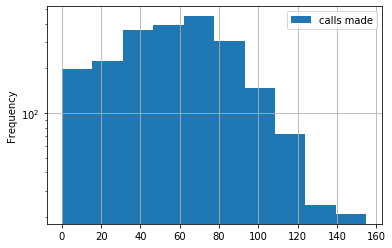

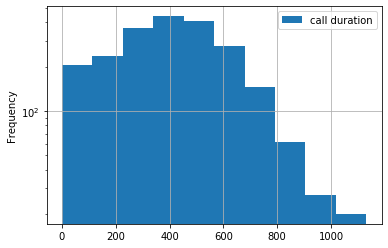

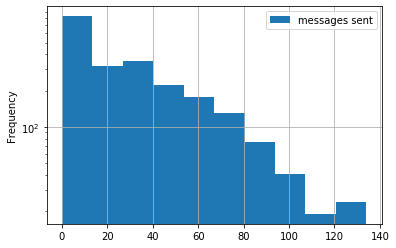

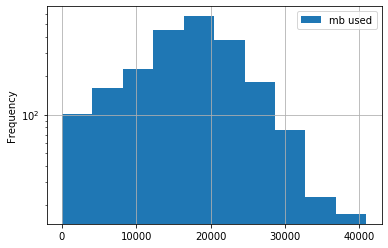

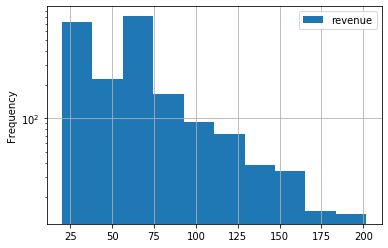

In [61]:
for i in df_columns: 
    filtered_df[[i]].plot(kind='hist',grid=True,logy =True)

Our data was almost skrewd right. We have removed outliers using zscore, and store the filtred data to an new dataframe. 
we can say here that we have an almost normal distribution in our filtred data.

**Analysing customers behavior**

In [62]:
# minutes for users of each plan per month
one_table.groupby('plan')['call duration'].agg([np.mean, np.var, np.std])

,mean,var,std
plan,,,
surf,428.749523,54968.279461,234.453150
ultimate,430.450000,57844.464812,240.508762


In [63]:
# difference in average monthly call duration
one_table.groupby('plan')['call duration']. describe()

,count,mean,std,min,25%,50%,75%,max
plan,,,,,,,,
surf,1573.0,428.749523,234.453150,0.0,272.0,425.0,576.00,1510.0
ultimate,720.0,430.450000,240.508762,0.0,260.0,424.0,565.25,1369.0


In [64]:
# filtered data for the ultimate plan
ultimate_data = one_table.query("plan == 'ultimate'")
ultimate_plan = ultimate_data[['calls made', 'call duration', 'messages sent', 'mb used', 'revenue']]

ultimate_plan_filtered = ultimate_plan[(np.abs(stats.zscore(ultimate_plan)) < 3).all(axis=1)]
ultimate_plan_filtered = ultimate_plan_filtered.reset_index(drop=True, inplace=False)
ultimate_plan_filtered.describe()

,calls made,call duration,messages sent,mb used,revenue
count,677.000000,677.000000,677.000000,677.000000,677.000000
mean,58.970458,418.196455,34.302806,16877.093058,70.568685
std,29.979860,216.700769,31.274291,6916.348803,3.677063
min,0.000000,0.000000,0.000000,0.000000,70.000000
25%,36.000000,260.000000,5.000000,13312.000000,70.000000
50%,60.000000,420.000000,28.000000,17408.000000,70.000000
75%,78.000000,546.000000,56.000000,20480.000000,70.000000
max,159.000000,1111.000000,139.000000,35840.000000,105.000000


In [65]:
# filtered data for the surf plan
surf_data = one_table.query("plan == 'surf'")
surf_plan = surf_data[['calls made', 'call duration', 'messages sent', 'mb used', 'revenue']]

surf_plan_filtered = surf_plan[(np.abs(stats.zscore(surf_plan)) < 3).all(axis=1)]
surf_plan_filtered = surf_plan_filtered.reset_index(drop=True, inplace=False)
surf_plan_filtered.describe()

,calls made,call duration,messages sent,mb used,revenue
count,1508.000000,1508.000000,1508.000000,1508.000000,1508.000000
mean,58.357427,418.277188,28.301724,16553.761273,55.500756
std,30.313364,222.179680,28.408758,7093.722639,43.459006
min,0.000000,0.000000,0.000000,0.000000,20.000000
25%,38.000000,263.000000,2.000000,12288.000000,20.000000
50%,59.000000,416.500000,23.000000,17408.000000,40.000000
75%,78.000000,565.000000,44.000000,21504.000000,80.000000
max,155.000000,1131.000000,130.000000,35840.000000,224.230000


**Variance for the surf plan**

In [66]:
for column in surf_plan_filtered:
    surf_plan_filtered[column].var()
    print('Variance of ' + column + ' is: {: >5.2f}'.format(surf_plan_filtered[column].var()))

Variance of calls made is: 918.90
Variance of call duration is: 49363.81
Variance of messages sent is: 807.06
Variance of mb used is: 50320900.88
Variance of revenue is: 1888.69


**Variance for the ultimate plan**

In [67]:
for column in ultimate_plan_filtered:
    ultimate_plan_filtered[column].var()
    print('Variance of ' + column + ' is: {: >5.2f}'.format(ultimate_plan_filtered[column].var()))

Variance of calls made is: 898.79
Variance of call duration is: 46959.22
Variance of messages sent is: 978.08
Variance of mb used is: 47835880.77
Variance of revenue is: 13.52


**`calls made`**

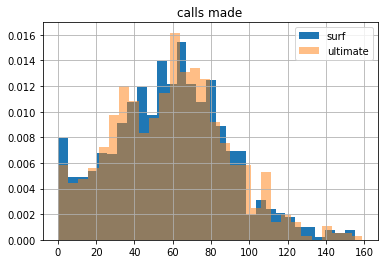

In [68]:
plot_hists(surf_plan_filtered,ultimate_plan_filtered,'calls made')

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


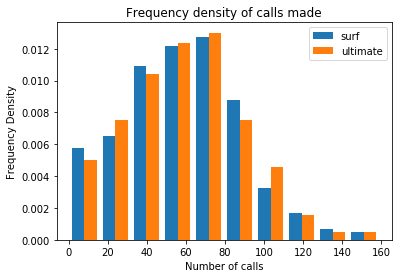

In [69]:
#density hist for nmbr of calls per month frequency density 
plt.hist([surf_plan_filtered['calls made'], ultimate_plan_filtered['calls made']], label=['surf','ultimate'],density=True)
plt.legend()
plt.ylabel('Frequency Density')
plt.xlabel('Number of calls')
plt.title('Frequency density of calls made');

**`call duration`**

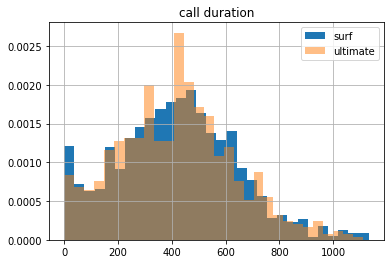

In [70]:
plot_hists(surf_plan_filtered,ultimate_plan_filtered,'call duration')

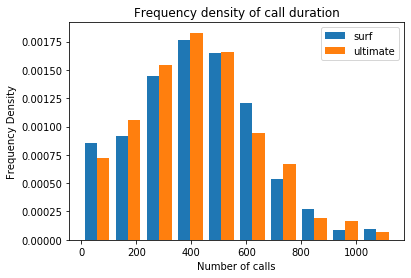

In [71]:
#density hist for nmbr of calls per month frequency density 
plt.hist([surf_plan_filtered['call duration'], ultimate_plan_filtered['call duration']], label=['surf','ultimate'],density=True)
plt.legend()
plt.ylabel('Frequency Density')
plt.xlabel('Number of calls')
plt.title('Frequency density of call duration');

**`messages sent`**

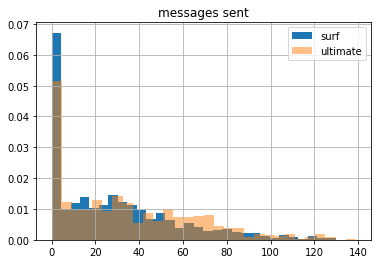

In [72]:
plot_hists(surf_plan_filtered,ultimate_plan_filtered,'messages sent')

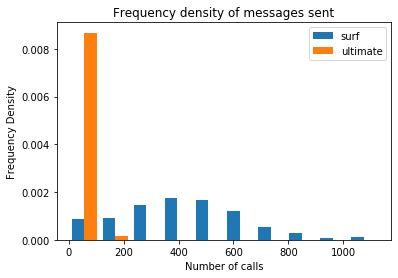

In [73]:
#density hist for nmbr of calls per month frequency density 
plt.hist([surf_plan_filtered['call duration'], ultimate_plan_filtered['messages sent']], label=['surf','ultimate'],density=True)
plt.legend()
plt.ylabel('Frequency Density')
plt.xlabel('Number of calls')
plt.title('Frequency density of messages sent');

**`mb used`**

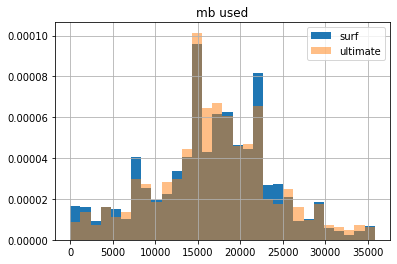

In [74]:
plot_hists(surf_plan_filtered,ultimate_plan_filtered,'mb used')

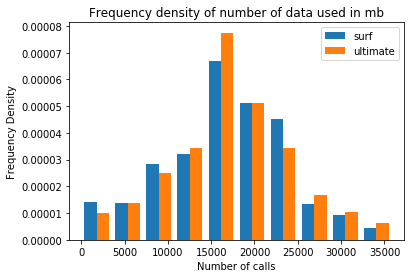

In [75]:
#density hist for nmbr of calls per month frequency density 
plt.hist([surf_plan_filtered['mb used'], ultimate_plan_filtered['mb used']], label=['surf','ultimate'],density=True)
plt.legend()
plt.ylabel('Frequency Density')
plt.xlabel('Number of calls')
plt.title('Frequency density of number of data used in mb');

**Conclusion**

- the **ultimate** users make -on the average- 
    - 58 calls, and 
    - 418 minutes per month, 
    - send 34 messages
    - use 16877 mb per month
    - variance of: `calls made` = 898.79, `messages sent` = 978
- the **surf** users make -on the average- 
    - 58 calls, and 
    - 418 minutes per month, 
    - send 28 messages
    - use 16553 mb per month
    - variance of: `calls made` = 918.90, `messages sent` = 807

- We can see from the distribution that:
    - the use of calls (`calls made`) from **surf** users is much more than **ultimate**
    - **ultimate** plan has more `call duration` per month than **surf** plan
    - **surf** plan has more total `messages sent` per month than **ultimate** plan
    - both **surf** and **ultimate** have almost the same distribution for volume of internet (`mb used`) per month

# <a id="5">Test the hypotheses</a>

- The average revenue from users of Ultimate and Surf calling plans differs.
- The average revenue from users in NY-NJ area is different from that of the users from other regions.

You decide what alpha value to use.

Explain:

- How you formulated the null and alternative hypotheses.
- What criterion you used to test the hypotheses and why.

1. **The average revenue from users of Ultimate and Surf calling plans differs.**

**Null Hypothesis** No difference between average revenue from users of Ultimate and Surf calling plans

H0: 
- Average revenue per month for Ultimate users = Average revenue per month for Surf users

H1:
- Average revenue per month for Ultimate users != Average revenue per month for Surf users

alpha = 0.05

If 
- p-value < alpha: reject H0
- p-value > alpha: fail to reject H0

In [76]:
h_ultimate = ultimate_plan_filtered['revenue']
h_surf = surf_plan_filtered['revenue']

In [77]:
alpha = 0.05

In [78]:
results1 = st.ttest_ind(h_ultimate, h_surf, equal_var = False)
print('p-value = {}'.format(results1.pvalue))
if results1.pvalue < alpha:
    print('we reject the null hypothesis')
else:
    print('we fail to reject the null hypothesis')

p-value = 1.3114892927704795e-38
we reject the null hypothesis


Average revenue per month for **Ultimate** users is different from Average revenue per month for **Surf** users.
We reject the H0.

2.**The average revenue from users in NY-NJ area is different from that of the users from other regions.**

H0: 
- The average revenue from users in NY-NJ area = Average revenue for users from other regions

H1:
- The average revenue from users in NY-NJ area != Average revenue for users from other regions

alpha = 0.05

In [79]:
ny_nj = one_table.query('city == "New York-Newark-Jersey City, NY-NJ-PA MSA"')['revenue']

In [80]:
other_regions = one_table.query('city != "New York-Newark-Jersey City, NY-NJ-PA MSA"')['revenue']

In [81]:
#mean revenue of users from new jersey area
ny_nj.mean()

59.921352785145885

In [82]:
#mean revenue of users from other regions than new jersey area
other_regions.mean()

65.22277139874738

In [83]:
#testing the hypothesis
results2 = st.ttest_ind(ny_nj, other_regions, equal_var = False)
print('p-value = {}'.format(results2.pvalue))
if results2.pvalue < alpha:
    print('we reject the null hypothesis')
else:
    print('we fail to reject the null hypothesis')

p-value = 0.03352561588530057
we reject the null hypothesis


- For our test hypothesis we used t-test and a significance level of 0.05.
- We conclude that the mean of the revenue between newyork newjersey is defferent from the mean of the revenue from other areas althought we don't have any information about how much they are different.

# <a id="6">Overall conclusion</a>

In conclusion,
- ultimite plan users have more call duration, text messages and volume data usage, and also revenue than surf plan
- surf plan users use more call service than ultimate plan
- avg revenue from users in New York-New Jersey is lower than other area users
- surf plan has more users than the ultimate plan, but
- ultimate plan seems to be more profitable than surf plan